合并后的 DataFrame 大小： (700, 11)


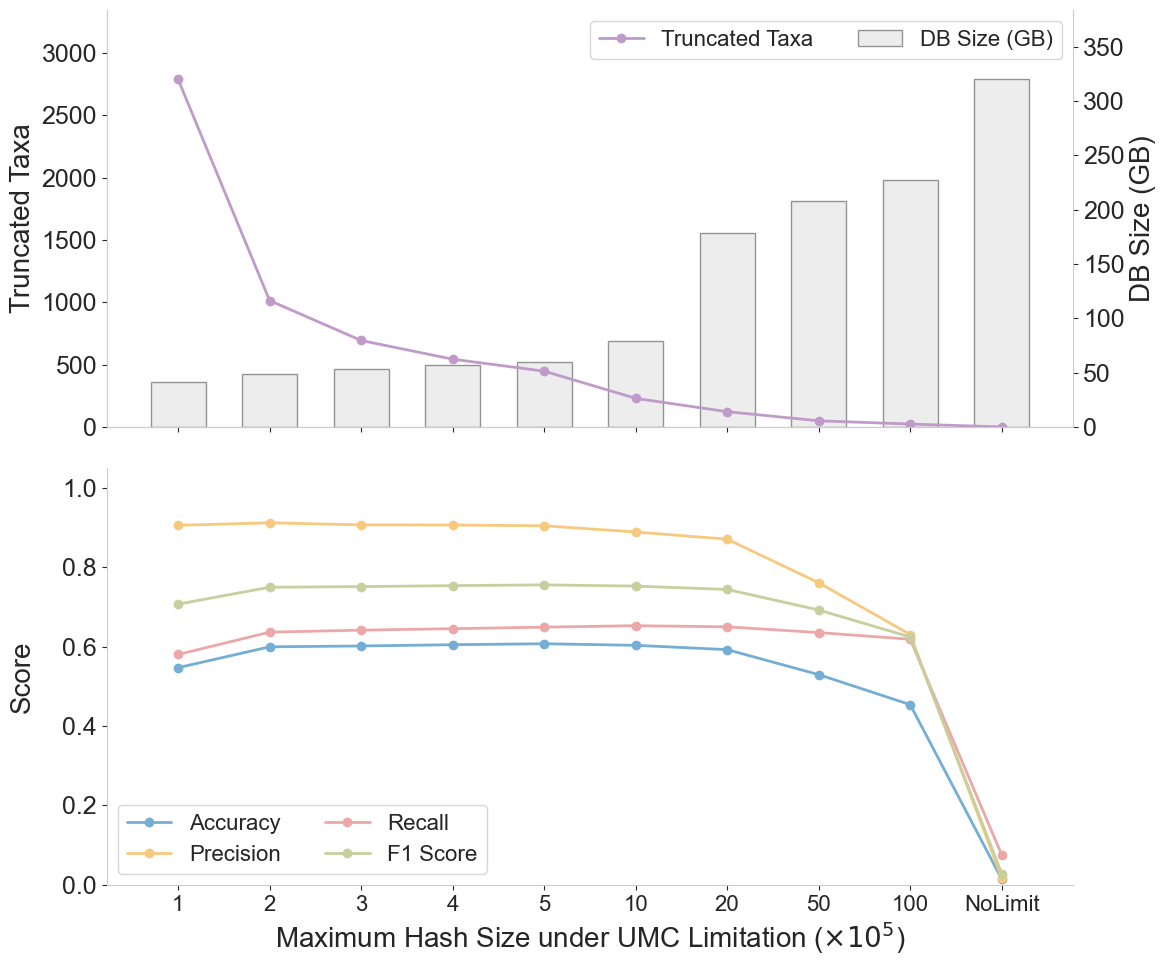

In [29]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

########################################
# 1) 全局风格设置
########################################
plt.rcParams.update({
    'font.family': 'Arial',  # 设置全局字体
    'axes.unicode_minus': False  # 解决负号显示问题
})
mpl.rcParams.update({
    'font.size': 18,         # 全局文本字体大小
    'axes.titlesize': 16,    # 坐标轴标题字体大小
    'axes.labelsize': 20,    # 坐标轴标签字体大小
    'xtick.labelsize': 16,   # x轴刻度标签字体大小
    'ytick.labelsize': 18,   # y轴刻度标签字体大小
    'legend.fontsize': 18,   # 图例字体大小
    'figure.titlesize': 24,  # 整体图标题大小
})
sns.set_palette("deep") 
sns.set_style("whitegrid", {
    'axes.grid': False, 
    'ytick.left': True, 
    'xtick.bottom': True
})

########################################
# 2) 读取并汇总 classification.csv 里的性能指标
########################################
# 假设你的 CSV 放在 d 目录下，每个文件名包含 "completeXw_classification.csv"
d = "../../../学术/项目/Chimera/Experiment/Classify/benchmark_results_maxhashs"
csv_pattern = os.path.join(d, "*classification.csv")
csv_files = glob.glob(csv_pattern)

df_list = []
for f in csv_files:
    df_tmp = pd.read_csv(f)
    
    basename = os.path.basename(f)
    db_name = "unknownDB"
    parts = basename.split("_")
    for p in parts:
        if p.startswith("complete"):
            db_name = p
            break
    
    df_tmp["Database"] = db_name
    df_list.append(df_tmp)

df_all = pd.concat(df_list, ignore_index=True)
print("合并后的 DataFrame 大小：", df_all.shape)

# 对 [Database, Taxonomic Rank] 分组，计算平均值
df_grouped = df_all.groupby(["Database","Taxonomic Rank"], as_index=False).agg({
    "Accuracy":  "mean",
    "Precision": "mean",
    "Recall":    "mean",
    "F1 Score":  "mean"
})

# 只保留 Species Rank
df_species = df_grouped[df_grouped["Taxonomic Rank"]=="Species"].copy()

# 数据库顺序
db_order = [
    "complete100w", "complete200w", "complete300w", "complete400w", "complete500w",
    "complete1000w", "complete2000w", "complete5000w", "complete1e", "completeUnlimit"
]

# 显示在 X 轴上的重命名 (单位: ×10^5)
db_rename_map = {
    "complete100w":    "1",
    "complete200w":    "2",
    "complete300w":    "3",
    "complete400w":    "4",
    "complete500w":    "5",
    "complete1000w":   "10",
    "complete2000w":   "20",
    "complete5000w":   "50",
    "complete1e":      "100",
    "completeUnlimit": "NoLimit"
}

# 按顺序提取 df_species
df_species = df_species[df_species["Database"].isin(db_order)].copy()
df_species.set_index("Database", inplace=True)

# 如果有某些数据库缺失，可以在此补 NaN
for db in db_order:
    if db not in df_species.index:
        df_species.loc[db] = [np.nan, np.nan, np.nan, np.nan, "Species"]

df_species = df_species.loc[db_order]

########################################
# 3) 其它外部数据：Truncated Taxa & DB Size
########################################
truncated_taxa_map = {
    "complete100w":    2786,
    "complete200w":    1013,
    "complete300w":    693,
    "complete400w":    543,
    "complete500w":    447,
    "complete1000w":   229,
    "complete2000w":   122,
    "complete5000w":   49,
    "complete1e":      23,
    "completeUnlimit": 0
}
db_size_map = {
    "complete100w":    41.1,
    "complete200w":    49.1,
    "complete300w":    53.6,
    "complete400w":    57.1,
    "complete500w":    60.0,
    "complete1000w":   79.4,
    "complete2000w":   178.6,
    "complete5000w":   208.0,
    "complete1e":      227.1,
    "completeUnlimit": 320.0
}

taxa = [truncated_taxa_map[db] for db in db_order]
db_sizes = [db_size_map[db] for db in db_order]

x_labels = [db_rename_map[db] for db in db_order]
x = np.arange(len(db_order))

########################################
# 4) 创建上下子图：上方(Truncated Taxa + DB Size)，下方(4 指标)
########################################
fig, (ax_top, ax_bottom) = plt.subplots(
    nrows=2, ncols=1,
    sharex=True,
    figsize=(12, 10)
)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (A) 上方子图: 双 Y 轴
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax_top2 = ax_top.twinx()  # 右轴

# 左轴: Truncated Taxa 的折线图（紫色）
line1, = ax_top.plot(
    x, taxa,
    marker='o', linestyle='-', linewidth=2,
    color="#C09BC9",  # 紫色折线
    label="Truncated Taxa"
)
ax_top.set_ylabel("Truncated Taxa")
ax_top.set_ylim(0, max(taxa)*1.2)
# for i, val in enumerate(taxa):
#     ax_top.text(x[i], val+80, str(val), ha='center', fontsize=14, color='black')

# 右轴: DB Size (GB) 的柱状图（灰色）
bar_width = 0.6
bars = ax_top2.bar(
    x, db_sizes,
    width=bar_width,
    alpha=0.4,
    color="lightgray",
    edgecolor="black",
    label="DB Size (GB)"
)
ax_top2.set_ylabel("DB Size (GB)")
ax_top2.set_ylim(0, max(db_sizes)*1.2)

# 合并上半部分的图例，并放在右上角
lines1, labels1 = ax_top.get_legend_handles_labels()
lines2, labels2 = ax_top2.get_legend_handles_labels()
ax_top.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=16,ncol=2)

# 调整双轴的层级，使紫色折线在灰色柱状图之上
ax_top.set_zorder(3)
ax_top.patch.set_visible(False)
ax_top2.set_zorder(2)

sns.despine(ax=ax_top, top=True, right=True)
sns.despine(ax=ax_top2, top=True, right=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (B) 下方子图: 4 个性能指标（改为折线图）
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
colors  = ["#74AED4", "#F7C97E", "#ECA8A9", "#C6CF9D"]

for i, metric in enumerate(metrics):
    metric_vals = df_species[metric].values.astype(float)
    ax_bottom.plot(
        x, metric_vals,
        marker='o', linestyle='-', linewidth=2,
        color=colors[i],
        label=metric,
        zorder=3
    )
    # # 在每个数据点上标注数值
    # for j, val in enumerate(metric_vals):
    #     ax_bottom.text(
    #         x[j], val, f"{val:.2f}",
    #         ha='center', va='bottom', fontsize=14
    #     )

ax_bottom.set_ylim(0, 1.05)
ax_bottom.set_ylabel("Score")
ax_bottom.set_xlabel(r"Maximum Hash Size under UMC Limitation ($\times 10^5$)")

# 将下半部分的图例也放到右上角
ax_bottom.legend(loc="best", ncol=2, fontsize=16)

sns.despine(ax=ax_bottom, top=True, right=True)
ax_bottom.set_xticks(x)
ax_bottom.set_xticklabels(x_labels, rotation=0, ha='center')

########################################
# 5) 收尾 & 保存
########################################
plt.tight_layout()
# 对齐上半部分和下半部分左侧的 Y 轴标题
fig.align_ylabels([ax_top, ax_bottom])
fig.savefig("combined_top_taxa_dbsize_bottom_metrics.svg", format="svg", dpi=300)
plt.show()


合并后的 DataFrame 大小： (700, 11)


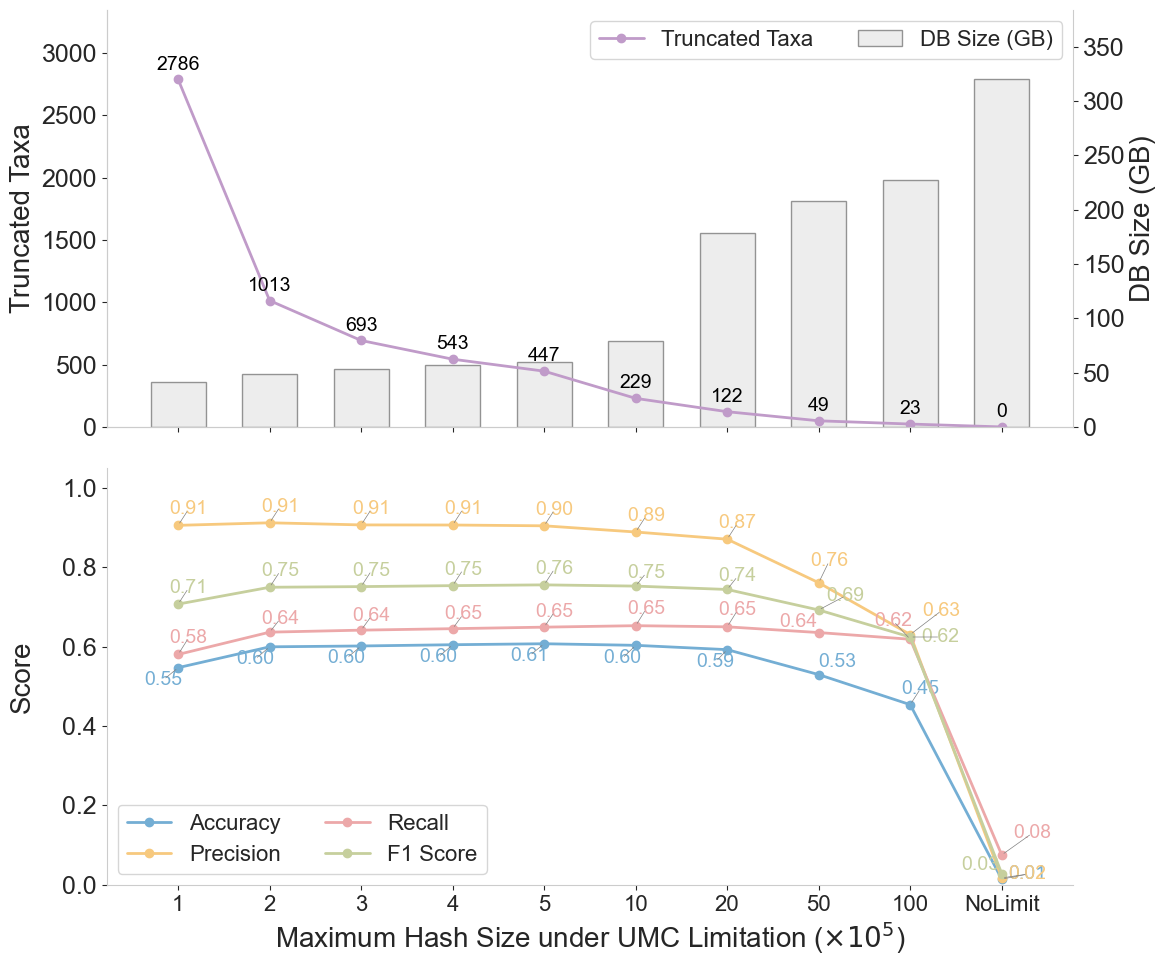

In [76]:
import os  
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from adjustText import adjust_text  # 引入 adjustText

########################################
# 1) 全局风格设置
########################################
plt.rcParams.update({
    'font.family': 'Arial',  # 设置全局字体
    'axes.unicode_minus': False  # 解决负号显示问题
})
mpl.rcParams.update({
    'font.size': 18,         # 全局文本字体大小
    'axes.titlesize': 16,    # 坐标轴标题字体大小
    'axes.labelsize': 20,    # 坐标轴标签字体大小
    'xtick.labelsize': 16,   # x轴刻度标签字体大小
    'ytick.labelsize': 18,   # y轴刻度标签字体大小
    'legend.fontsize': 18,   # 图例字体大小
    'figure.titlesize': 24,  # 整体图标题大小
})
sns.set_palette("deep") 
sns.set_style("whitegrid", {
    'axes.grid': False, 
    'ytick.left': True, 
    'xtick.bottom': True
})

########################################
# 2) 读取并汇总 classification.csv 里的性能指标
########################################
# 假设你的 CSV 放在 d 目录下，每个文件名包含 "completeXw_classification.csv"
d = "../../../学术/项目/Chimera/Experiment/Classify/benchmark_results_maxhashs"
csv_pattern = os.path.join(d, "*classification.csv")
csv_files = glob.glob(csv_pattern)

df_list = []
for f in csv_files:
    df_tmp = pd.read_csv(f)
    
    basename = os.path.basename(f)
    db_name = "unknownDB"
    parts = basename.split("_")
    for p in parts:
        if p.startswith("complete"):
            db_name = p
            break
    
    df_tmp["Database"] = db_name
    df_list.append(df_tmp)

df_all = pd.concat(df_list, ignore_index=True)
print("合并后的 DataFrame 大小：", df_all.shape)

# 对 [Database, Taxonomic Rank] 分组，计算平均值
df_grouped = df_all.groupby(["Database","Taxonomic Rank"], as_index=False).agg({
    "Accuracy":  "mean",
    "Precision": "mean",
    "Recall":    "mean",
    "F1 Score":  "mean"
})

# 只保留 Species Rank
df_species = df_grouped[df_grouped["Taxonomic Rank"]=="Species"].copy()

# 数据库顺序
db_order = [
    "complete100w", "complete200w", "complete300w", "complete400w", "complete500w",
    "complete1000w", "complete2000w", "complete5000w", "complete1e", "completeUnlimit"
]

# 显示在 X 轴上的重命名 (单位: ×10^5)
db_rename_map = {
    "complete100w":    "1",
    "complete200w":    "2",
    "complete300w":    "3",
    "complete400w":    "4",
    "complete500w":    "5",
    "complete1000w":   "10",
    "complete2000w":   "20",
    "complete5000w":   "50",
    "complete1e":      "100",
    "completeUnlimit": "NoLimit"
}

# 按顺序提取 df_species
df_species = df_species[df_species["Database"].isin(db_order)].copy()
df_species.set_index("Database", inplace=True)

# 如果有某些数据库缺失，可以在此补 NaN
for db in db_order:
    if db not in df_species.index:
        df_species.loc[db] = [np.nan, np.nan, np.nan, np.nan, "Species"]

df_species = df_species.loc[db_order]

########################################
# 3) 其它外部数据：Truncated Taxa & DB Size
########################################
truncated_taxa_map = {
    "complete100w":    2786,
    "complete200w":    1013,
    "complete300w":    693,
    "complete400w":    543,
    "complete500w":    447,
    "complete1000w":   229,
    "complete2000w":   122,
    "complete5000w":   49,
    "complete1e":      23,
    "completeUnlimit": 0
}
db_size_map = {
    "complete100w":    41.1,
    "complete200w":    49.1,
    "complete300w":    53.6,
    "complete400w":    57.1,
    "complete500w":    60.0,
    "complete1000w":   79.4,
    "complete2000w":   178.6,
    "complete5000w":   208.0,
    "complete1e":      227.1,
    "completeUnlimit": 320.0
}

taxa = [truncated_taxa_map[db] for db in db_order]
db_sizes = [db_size_map[db] for db in db_order]

x_labels = [db_rename_map[db] for db in db_order]
x = np.arange(len(db_order))

########################################
# 4) 创建上下子图：上方(Truncated Taxa + DB Size)，下方(4 指标)
########################################
fig, (ax_top, ax_bottom) = plt.subplots(
    nrows=2, ncols=1,
    sharex=True,
    figsize=(12, 10)
)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (A) 上方子图: 双 Y 轴
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax_top2 = ax_top.twinx()  # 右轴

# 左轴: Truncated Taxa 的折线图（紫色）
line1, = ax_top.plot(
    x, taxa,
    marker='o', linestyle='-', linewidth=2,
    color="#C09BC9",  # 紫色折线
    label="Truncated Taxa"
)
ax_top.set_ylabel("Truncated Taxa")
ax_top.set_ylim(0, max(taxa)*1.2)
for i, val in enumerate(taxa):
    ax_top.text(x[i], val+80, str(val), ha='center', fontsize=14, color='black')

# 右轴: DB Size (GB) 的柱状图（灰色）
bar_width = 0.6
bars = ax_top2.bar(
    x, db_sizes,
    width=bar_width,
    alpha=0.4,
    color="lightgray",
    edgecolor="black",
    label="DB Size (GB)"
)
ax_top2.set_ylabel("DB Size (GB)")
ax_top2.set_ylim(0, max(db_sizes)*1.2)

# 合并上半部分的图例，并放在右上角
lines1, labels1 = ax_top.get_legend_handles_labels()
lines2, labels2 = ax_top2.get_legend_handles_labels()
ax_top.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=16, ncol=2)

# 调整双轴的层级，使紫色折线在灰色柱状图之上
ax_top.set_zorder(3)
ax_top.patch.set_visible(False)
ax_top2.set_zorder(2)

sns.despine(ax=ax_top, top=True, right=True)
sns.despine(ax=ax_top2, top=True, right=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# (B) 下半部分: 4 个性能指标（折线图，使用 adjustText 调整数值标签）
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
colors  = ["#74AED4", "#F7C97E", "#ECA8A9", "#C6CF9D"]

# 用于存储所有文本对象，供 adjustText 调整
texts = []

for i, metric in enumerate(metrics):
    metric_vals = df_species[metric].values.astype(float)
    ax_bottom.plot(
        x, metric_vals,
        marker='o', linestyle='-', linewidth=2,
        color=colors[i],
        label=metric,
        zorder=3
    )
    # 在每个数据点上添加数值标签
    for j, val in enumerate(metric_vals):
        t = ax_bottom.text(
            x[j], val, f"{val:.2f}",
            ha='center', va='bottom', fontsize=14, color=colors[i]
        )
        texts.append(t)

ax_bottom.set_ylim(0, 1.05)
ax_bottom.set_ylabel("Score")
ax_bottom.set_xlabel(r"Maximum Hash Size under UMC Limitation ($\times 10^5$)")

# 将下半部分的图例也放到右上角
ax_bottom.legend(loc='best', ncol=2, fontsize=16)

sns.despine(ax=ax_bottom, top=True, right=True)
ax_bottom.set_xticks(x)
ax_bottom.set_xticklabels(x_labels, rotation=0, ha='center')

# 调用 adjustText 调整所有文本标签，防止重叠
adjust_text(texts, ax=ax_bottom, expand_text=(1.2,1.2), force_text=0.5,
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

########################################
# 5) 收尾 & 保存
########################################
plt.tight_layout()
fig.align_ylabels([ax_top, ax_bottom])
fig.savefig("combined_top_taxa_dbsize_bottom_metrics.svg", format="svg", dpi=300)
plt.show()
